# Understanding the Amazon rainforest from space

## Overview of Section
1. Split of test data/training data Justification
2. Weather models (Multi-classifier single labels)
3. Single Label Land Approach
4. Multi-label land approach
5. Combined Land/Weather approach


Given we are mostly interested in being able to tell where deforestation is occuring, we will simplify the land tags into naturally occuring phenomena 



In [2]:
import numpy as np # linear algebra
import pandas as pd 
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import scipy.stats
import seaborn as sns
import cv2
import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls
import random
import math
from skimage import io
import itertools
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from skimage import transform
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.multioutput import ClassifierChain
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
import warnings
warnings.filterwarnings('ignore')

## 1. Split of test training data
We are choosing to split the data 90 to 10 training to test. This is because 

We are including so much more data in the training set because some of the features are 

Nick/Wei please build in random shuffle of the data here.

In [10]:
#obtain processed training labels and data
labels = pd.read_csv('train_labels_clean.csv')
data = pd.read_csv('train_data_2.csv')
# Create training and test sets for weather labels by randomly splitting the original dataset as 90%/10%
train_data_weather, test_data_weather, train_labels_weather, test_labels_weather = train_test_split(data, labels.weather, test_size=0.1)
# Create training and test sets for land labels by randomly splitting the original dataset as 90%/10%
train_data_land, test_data_land, train_labels_land, test_labels_land = train_test_split(data, labels.land, test_size=0.1)
# Create training and test sets for multi-label land labels by randomly splitting the original dataset as 90%/10%
labels['tags_split'] = labels['land'].map(lambda row: row.split(" "))
mlb = MultiLabelBinarizer()
multi_labels = mlb.fit_transform(labels['tags_split'])
train_data_land_multi, test_data_land_multi, train_labels_land_multi, test_labels_land_multi= train_test_split(data, multi_labels, test_size=0.1)

## Weather feature identification

Weather feature identification is being performed for cloud and haze removal. This facilitates the successive water, land and primary feature identification.

1. Create Useful fucntions
2. Try a variety of models
3. Improve on the most successful model preformance

 ## 1. Output Functions
 

In [11]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def single_model_output(pipeline, scores, train_data, train_label, test_data, test_label):
    pipeline.fit(train_data,train_label)
    model_predictions=pipeline.predict(test_data)

    print("Cross-Validation\n Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) 

    con_fu=confusion_matrix(test_label, model_predictions)
    class_list=sorted(list(set(test_label)))
    return plot_confusion_matrix(con_fu, classes=class_list)

def multiple_model_output(pipeline, scores, train_data, train_label, test_data, test_label):
    pipeline.fit(train_data,train_label)
    model_predictions=pipeline.predict(test_data)
    print(classification_report(test_label,model_predictions))

    print("Cross-Validation\n Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) 

## 2. Logistic Regression

In [12]:
# Setup the pipeline for logistics regression
LG_model =LogisticRegression(tol=0.02)
LG_pipeline = Pipeline([
    ('LogisticsRegression', LG_model),
])

LG_scores = cross_val_score(LG_pipeline,
                            train_data_weather,
                            train_labels_weather,
                            cv=10,
                            scoring='f1_micro')

               precision    recall  f1-score   support

        clear       0.82      0.95      0.88      2829
       cloudy       0.67      0.55      0.60       214
         haze       0.66      0.47      0.55       280
partly_cloudy       0.68      0.37      0.48       725

  avg / total       0.77      0.79      0.77      4048

Cross-Validation
 Accuracy: 0.77 (+/- 0.01)


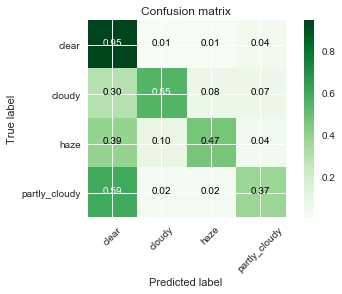

In [24]:
# Check output for Logistics Regression
single_model_output(LG_pipeline, LG_scores, train_data_weather, train_labels_weather, test_data_weather, test_labels_weather)

THis model works okay for clear weather - but not really for anything else. Log Reg probably not the way to go.

Which labels is it confusing? Everything for Clear by the look of if!

In [ ]:
# Setup the pipeline for decision tree. Use GridSearchCV to find the best depth for decision tree
param_grid = dict(DecisionTrees__max_depth=[5, 10,20,50,100], m)
DT_model=DecisionTreeClassifier(min_samples_leaf=20)
DT_pipeline = Pipeline([
    ('DecisionTrees', DT_model),
])

grid_tree = GridSearchCV(DT_pipeline, param_grid)
grid_tree.fit(train_data_weather, train_labels_weather)
tree_preds = grid_tree.predict(test_data_weather)

In [ ]:
print("The best tree parameters are: " + str(grid_tree.best_params_))

In [15]:
# Set up the pipeline for decision tree with the best depth = 75
DT_model_best =DecisionTreeClassifier(min_samples_leaf=5, max_depth=75)
DT_pipeline_best = Pipeline([
    ('DecisionTrees', DT_model_best),
])

DT_scores = cross_val_score(DT_pipeline_best,
                            train_data_weather,
                            train_labels_weather,
                            cv=10,
                            scoring='f1_micro')

               precision    recall  f1-score   support

        clear       0.92      0.93      0.92      2829
       cloudy       0.73      0.69      0.71       214
         haze       0.62      0.57      0.59       280
partly_cloudy       0.77      0.78      0.78       725

  avg / total       0.86      0.86      0.86      4048

Cross-Validation
 Accuracy: 0.86 (+/- 0.01)


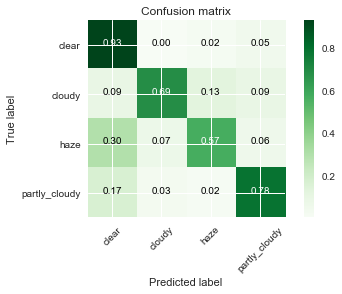

In [23]:
# Check output for Decision Tree
single_model_output(DT_pipeline_best, DT_scores, train_data_weather, train_labels_weather, test_data_weather, test_labels_weather)

In [18]:
# Setup the pipeline for random forest. Use GridSearchCV to find the best parameters 
param_grid = dict(RandomForest__max_depth=[5, 10,20,50,75],
                 RandomForest__n_estimators = [20,50,100,200],
                 RandomForest__min_samples_leaf = [2,3,4,5,10])

RF_model =RandomForestClassifier()
RF_pipeline = Pipeline([
    ('RandomForest', RF_model),
])

grid_forest = GridSearchCV(RF_pipeline, param_grid)
grid_forest.fit(train_data_weather, train_labels_weather)
forest_preds = grid_forest.predict(test_data_weather)

KeyboardInterrupt: 

In [ ]:
print("The best tree parameters are: " + str(grid_forest.best_params_))

In [20]:
# Set up the pipeline for random forest with the best parameters
RF_model_best =RandomForestClassifier(n_estimators=20, min_samples_leaf=5,max_depth=75)
RF_pipeline_best = Pipeline([
    ('RandomForest', RF_model_best),
])

RF_scores = cross_val_score(RF_pipeline_best, 
                                          train_data_weather,
                                          train_labels_weather, 
                                          cv=10,
                                          scoring='f1_micro')

               precision    recall  f1-score   support

        clear       0.92      0.98      0.95      2829
       cloudy       0.84      0.76      0.80       214
         haze       0.79      0.64      0.71       280
partly_cloudy       0.90      0.80      0.85       725

  avg / total       0.91      0.91      0.91      4048

Cross-Validation
 Accuracy: 0.90 (+/- 0.01)


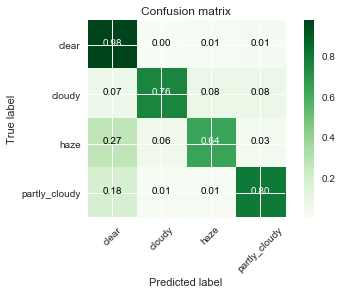

In [22]:
# Check output for Random Forest
single_model_output(RF_pipeline_best, RF_scores, train_data_weather, train_labels_weather, test_data_weather, test_labels_weather)

This is now a fairly accurate model for the clear and partly cloudy models. Both cloudy and hazy are getting confused with clear.

## 2. Land Models - single label models

In [ ]:
# Setup the pipeline for random forest. Use GridSearchCV to find the best parameters 
param_grid = dict(RandomForest__max_depth=[5, 10,20,50,75],
                 RandomForest__n_estimators = [20,50,100,200],
                 RandomForest__min_samples_leaf = [2,3,4,5,10])
RF_model_land =RandomForestClassifier()
RF_pipeline_land = Pipeline([
    ('RandomForest', RF_model_land),
])

grid_forest_land = GridSearchCV(RF_pipeline_land, param_grid)
grid_forest_land.fit(train_data_land, train_label_land)
forest_preds_land = grid_forest_land.predict(test_data_land)

In [ ]:
print("The best tree depth is: " + str(grid_forest_land.best_params_))

In [27]:
# Set up the pipeline for random forest with the best parameters
RF_model_land_best =RandomForestClassifier(n_estimators=100, min_samples_leaf=2,max_depth=10)
RF_pipeline_land_best = Pipeline([
    ('RandomForest', RF_model_land_best),
])

RF_land_scores = cross_val_score(RF_pipeline_land_best, 
                                          train_data_land,
                                          train_labels_land, 
                                          cv=10,
                                          scoring='f1_micro')

In [ ]:
# Check output for Random Forest
single_model_output(RF_pipeline_land_best, RF_land_scores, train_data_land, train_labels_land, test_data_land, test_labels_land)

The model does extremely badly on picking up models with water - it is fairly efficient at picking up primar and primary tags vs other

This is clearly not a good model, as by forcing the labels to separate we lose all the predictive power contained in other labels. I.e. what's in a primary water image, will hopefully help use to predict whats in a water other tag as well.

# Multi-label models

Below is Wei's crossvalidation attempt. There is a bug that I didn't get time to fix. If someone can help that would be great!

In [ ]:
# Setup the pipeline for random forest. Use GridSearchCV to find the best depth 
param_grid = {'estimator__max_depth':[5,10,20,50,75], 
              'estimator__n_estimators':[20,50,100,200],
              'estimator__min_samples_leaf':[2,3,4,5,10]}

DT_model_land_multi = OneVsRestClassifier(RandomForestClassifier())

grid_forest_land_multi = GridSearchCV(DT_model_land_multi, param_grid)
grid_forest_land_multi.fit(train_data_land_multi, train_label_land_multi)
forest_preds_land_multi = grid_forest_land_multi.predict(test_data_land_multi)

In [ ]:
print("The best tree parameters are: " + str(grid_forest_land_multi.best_params_))

In [ ]:
# Set up the pipeline for random forest with the best parameters
DT_model_land_multi_best =OneVsRestClassifier(RandomForestClassifier(n_estimators=200, min_samples_leaf=4,max_depth=50))

DT_land_multi_pipeline = Pipeline([
    ('RandomForest', DT_model_land_multi_best),
])

DT_land_multi_scores = cross_validation.cross_val_score(DT_model_land_multi_best, 
                                          train_data_land_multi,
                                          train_label_land_multi, 
                                          cv=10,
                                          scoring='f1_micro')

In [ ]:
# Check output for Random Forest
model_output_multi(DT_land_multi_pipeline, DT_land_multi_scores, train_data_land_multi, test_label_land_multi, test_data_land_multi, test_label_land_multi)

Below is the old code. Leave here for reference.

In [13]:
def ovr_model(estimator, data_train,labels_train,data_test,labels_test):
    model=OneVsRestClassifier(estimator).fit(data_train,labels_train)
    model_predict=model.predict(data_test)
    print('OVR with ' + str(model.get_params().get('estimator'))[0:str(model.get_params().get('estimator')).find('(')]+' estimator: ')
    print(classification_report(labels_test,model_predict))
    cross_validation(model, data_train, labels_train)
    confusion_mat(labels_test.argmax(axis=1), model_predict.argmax(axis=1))
ovr_model(RandomForestClassifier(n_estimators=50,max_depth=50, min_samples_leaf=2), train_data_land_multi,train_labels_land_multi,test_data_land_multi,test_labels_land_multi)
ovr_model(DecisionTreeClassifier(max_depth=50, min_samples_leaf=10), train_data_land_multi,train_labels_land_multi,test_data_land_multi,test_labels_land_multi)

OVR with RandomForestClassifier estimator: 
             precision    recall  f1-score   support

          0       0.83      0.73      0.77       210
          1       0.85      0.82      0.83      1551
          2       0.97      0.99      0.98      3738
          3       0.82      0.59      0.69       714

avg / total       0.92      0.89      0.90      6213

Cross-Validation
 Accuracy: 0.77 (+/- 0.00)
Confusion Matrix
[[ 160    7   38    5]
 [   9 1264  273    5]
 [  26  207 2019    3]
 [  14    2    6   10]]
OVR with DecisionTreeClassifier estimator: 
             precision    recall  f1-score   support

          0       0.70      0.69      0.70       210
          1       0.80      0.78      0.79      1551
          2       0.97      0.98      0.98      3738
          3       0.64      0.57      0.61       714

avg / total       0.88      0.87      0.88      6213

Cross-Validation
 Accuracy: 0.69 (+/- 0.01)
Confusion Matrix
[[ 168   11   24    7]
 [  24 1202  323    2]
 [  47  2

In [14]:
def classifier_chain_model(estimator, data_train,labels_train,data_test,labels_test):
    model = ClassifierChain(estimator).fit(data_train, labels_train)
    model_predict=model.predict(data_test)
    print('Classifier Chain with ' + str(model.get_params().get('base_estimator'))[0:str(model.get_params().get('base_estimator')).find('(')]+' base estimator: ')
    print(classification_report(labels_test,model_predict))
    cross_validation(model, data_train, labels_train)
    confusion_mat(labels_test.argmax(axis=1), model_predict.argmax(axis=1))
classifier_chain_model(RandomForestClassifier(n_estimators=50,max_depth=50, min_samples_leaf=2), train_data_land_multi,train_labels_land_multi,test_data_land_multi,test_labels_land_multi)
classifier_chain_model(DecisionTreeClassifier(max_depth=50, min_samples_leaf=10), train_data_land_multi,train_labels_land_multi,test_data_land_multi,test_labels_land_multi)

Classifier Chain with RandomForestClassifier base estimator: 
             precision    recall  f1-score   support

          0       0.84      0.73      0.78       210
          1       0.85      0.82      0.84      1551
          2       0.97      0.99      0.98      3738
          3       0.83      0.60      0.70       714

avg / total       0.92      0.90      0.91      6213

Cross-Validation
 Accuracy: 0.77 (+/- 0.00)
Confusion Matrix
[[ 154   13   33   10]
 [   5 1276  270    0]
 [  18  206 2024    7]
 [   8    2    5   17]]
Classifier Chain with DecisionTreeClassifier base estimator: 
             precision    recall  f1-score   support

          0       0.71      0.71      0.71       210
          1       0.80      0.77      0.79      1551
          2       0.97      0.98      0.97      3738
          3       0.63      0.55      0.59       714

avg / total       0.88      0.87      0.87      6213

Cross-Validation
 Accuracy: 0.71 (+/- 0.01)
Confusion Matrix
[[ 151   20   32   

In [15]:
def k_neighbors_model(k,data_train,labels_train,data_test,labels_test):
    model = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree').fit(data_train, labels_train)
    model_predict=model.predict(data_test)
    print(classification_report(labels_test,model_predict))
    cross_validation(model, data_train, labels_train)
    confusion_mat(labels_test.argmax(axis=1), model_predict.argmax(axis=1))
for i in [1,5,10,12,13]:
    print("K-Neighbors: " + str(i))
    k_neighbors_model(i,train_data_land_multi,train_labels_land_multi,test_data_land_multi,test_labels_land_multi)   

K-Neighbors: 1
             precision    recall  f1-score   support

          0       0.44      0.47      0.46       210
          1       0.60      0.59      0.59      1551
          2       0.96      0.95      0.95      3738
          3       0.38      0.35      0.36       714

avg / total       0.78      0.78      0.78      6213

Cross-Validation
 Accuracy: 0.53 (+/- 0.00)
Confusion Matrix
[[  99   61   46    4]
 [  76  915  557    3]
 [  42  547 1654   12]
 [   8    6   10    8]]
K-Neighbors: 5
             precision    recall  f1-score   support

          0       0.68      0.46      0.55       210
          1       0.68      0.63      0.65      1551
          2       0.96      0.98      0.97      3738
          3       0.63      0.25      0.36       714

avg / total       0.84      0.79      0.80      6213

Cross-Validation
 Accuracy: 0.60 (+/- 0.01)
Confusion Matrix
[[  99   47   54   10]
 [  28  975  546    2]
 [  20  406 1822    7]
 [   8    3   11   10]]
K-Neighbors: 10
    

The model is now doing a better job at picking up the rare labels, though it struggles a lot with the water label. 
It is mostly good at detecting the primary label because it appears so often, though it does a relatively good job with the other label, and the none label (which should mostly be used for cloudly image.

The model does well at picking clear, cloudy, primary and not much else. To better identify roads, and water edge extraction may 
help. We're also not taking advantage of correlation with the model here.

Interestingly the model isn't picking too many false positives (i.e. precision), but is picking a lot of false negatives(i.e. recall). This suggests we need to build more features to pick up land masses, roads and waters. 


Out of scope
Try Convultional Neural Networks
Ask June for help in Set-up